In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2

import os
print(os.listdir("../input"))


['train_sentiment', 'test', 'breed_labels.csv', 'train', 'test_images', 'test_sentiment', 'test_metadata', 'color_labels.csv', 'train_metadata', 'train_images', 'state_labels.csv']


In [49]:
treino = pd.read_csv('../input/train/train.csv')
teste = pd.read_csv('../input/test/test.csv')
exemplo_submissao = pd.read_csv('../input/test/sample_submission.csv')

treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

In [50]:
classe_raca = pd.read_csv('../input/breed_labels.csv')
classe_cor = pd.read_csv('../input/color_labels.csv')
classe_estado = pd.read_csv('../input/state_labels.csv')

In [51]:
# Captura todos os nomes e adiciona como uma lista
labels = treino['Name'].astype('category').cat.categories.tolist()
# Associa cada nome a um valor contínuo (neste caso o tamanho do nome)
replace_map_comp = {
    'Name' : {
        k: len(k) for k in labels
    }
}

treino.replace(replace_map_comp, inplace=True)
treino = pd.DataFrame(treino)
treino.fillna(0, inplace=True)

treino.describe()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,8.713600,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,7.425853,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,6.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,11.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,47.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


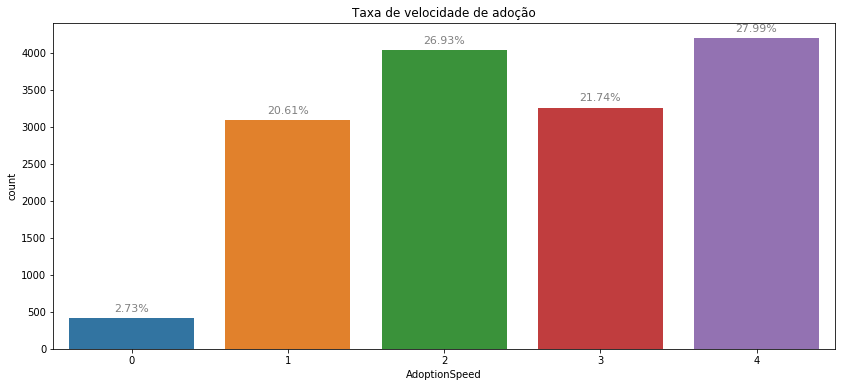

In [47]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=treino)
plt.title('Taxa de velocidade de adoção');
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / treino.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points')

****Pode-se notar que **2.73%** dos pets são adotados imediatamente, uma taxa muito pequena, provavelmente sorte do pet (ou algo influencia?). **27.99%** não são adotados no fim. Uma boa parte é adotada na primeira semana.

As classes possuem relacionamento linear, isto é, quanto maior o número pior a situação do pet. Poderemos então utilizar **classificação multiclasse** ou **regressão**.

O que influencia na adoção (Nomes, idade do pet, raça, cor)?

In [ ]:
print('Quantidade de dados de treino: {}'.format(len(treino)))

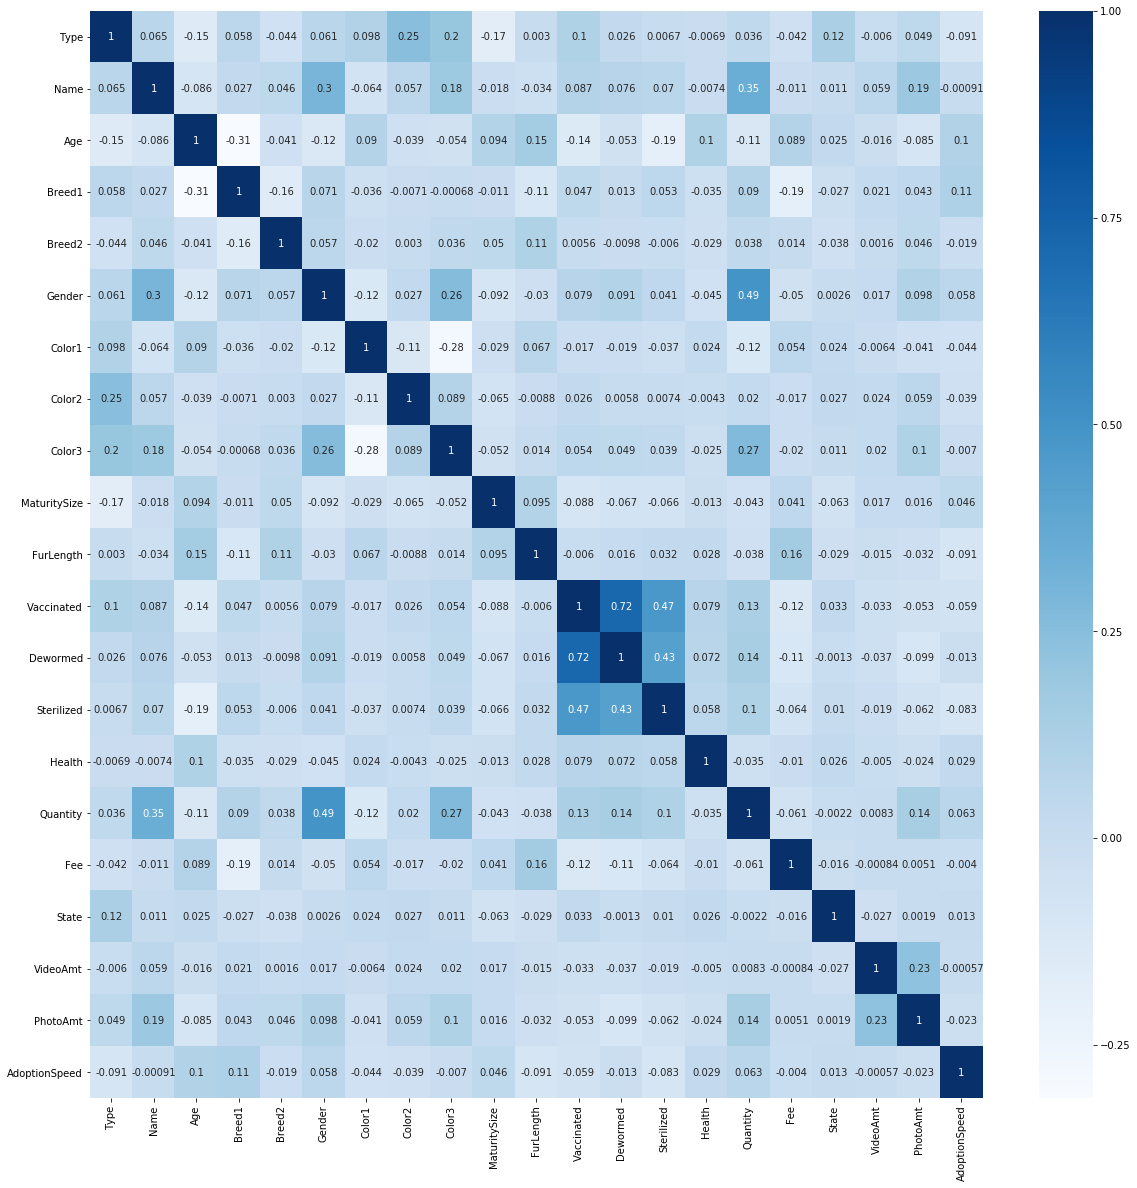

In [8]:
# Ver a relação das variáveis com um mapa de calor
plt.figure(figsize=(20,20))
sns.heatmap(treino.corr(), annot=True, cmap="Blues")

In [ ]:
# Criando matriz de correlação
#matriz_correlacao = treino.corr().abs()
# Selecionando apenas o triângulo superior da matriz de correlação
#triangulo_superior = matriz_correlacao.where(np.triu(np.ones(matriz_correlacao.shape), k=1).astype(np.bool))
# Capturando as features com correlação maior que 0.40
#para_descartar = [column for column in triangulo_superior.columns if any(triangulo_superior[column] > 0.40)]
# Descartando as features com alta correlação entre si
#treino.drop(treino[para_descartar], axis=1)

matriz_correlacao = treino.corr()
#Correlation with output variable
feature_alvo = abs(matriz_correlacao["AdoptionSpeed"])
#Selecting highly correlated features
features_relevantes = feature_alvo[feature_alvo>0.05]
print(features_relevantes)

#print(treino[["Age","Breed1"]].corr())
#print(treino[["Breed1","Gender"]].corr())
#print(treino[["Gender","FurLength"]].corr())
#print(treino[["FurLength","Vaccinated"]].corr())
#print(treino[["Vaccinated","Sterilized"]].corr())
#print(treino[["Sterilized","Quantity"]].corr())
#print(treino[["Quantity","Age"]].corr())

As we can see, only the features Type, Age, Breed1,Gender,FurLength, Vaccinated, Sterilized, and Quantity are highly correlated with the output variable MEDV. Hence we will drop all other features apart from these. However this is not the end of the process. One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other. If these variables are correlated with each other, then we need to keep only one of them and drop the rest. So let us check the correlation of selected features with each other. This can be done either by visually checking it from the above correlation matrix or from the code snippet below.

In [57]:
# As colunas 'Name', 'RescuerID', 'PetID' e 'Description' não possuem relação e portanto serão descartadas
# As alterações no dataset de treino são aplicadas no dataset de teste.
treino.drop(['RescuerID', 'PetID', 'Description'], axis=1, inplace=True)
teste.drop(['RescuerID', 'PetID', 'Description'], axis=1, inplace=True)

In [58]:
# Verificando se existem valores nullos
treino.isnull().sum()

Type             0
Name             0
Age              0
Breed1           0
Breed2           0
Gender           0
Color1           0
Color2           0
Color3           0
MaturitySize     0
FurLength        0
Vaccinated       0
Dewormed         0
Sterilized       0
Health           0
Quantity         0
Fee              0
State            0
VideoAmt         0
PhotoAmt         0
AdoptionSpeed    0
dtype: int64

In [59]:
# Separando em dados de treino e teste (validação)
predicao = treino.drop(['AdoptionSpeed'], axis=1)
classe_esperada = treino['AdoptionSpeed']
x_treino, x_validacao, y_treino, y_validacao = train_test_split(predicao, classe_esperada, test_size = 0.2, random_state = 0)

In [30]:
# Utilizamos um modelo mais básico para ter uma comparação
# Os próximos modelos precisarão ter mais que '32.91' de acurácia
arvore_decisao = DecisionTreeClassifier()
arvore_decisao.fit(x_treino, y_treino)
y_predito = arvore_decisao.predict(x_validacao)
acuracia_arvore_decisao = round(accuracy_score(y_predito, y_validacao) * 100, 2)
print(acuracia_arvore_decisao)

33.01


In [31]:
# Que tal tentar um classificador bayessiano gaussiano?
# Okay... Um ganho de alguns décimos 33.81
classificador_bayes_gauss = GaussianNB()
classificador_bayes_gauss.fit(x_treino, y_treino)
y_predito = classificador_bayes_gauss.predict(x_validacao)
acuracia_bayes_gauss = round(accuracy_score(y_predito, y_validacao) * 100, 2)
print(acuracia_bayes_gauss)

33.88


[0.3334875358193022, 0.3022720006992177, 0.3222139260273997, 0.331283619308042, 0.3342841537101796, 0.3404899420558964, 0.34335536208152845, 0.34335674375007247, 0.3455585681376104, 0.34555843364521655, 0.34742576813618337, 0.3475587900322229, 0.3502279929685807, 0.34929274606177196, 0.349959991723545, 0.3500937253233659, 0.3480924797525625, 0.34842545616377396, 0.3465583890522478, 0.34875950209274803, 0.34935950244949177, 0.34862794980258693, 0.35136364299582695, 0.35069310191366265, 0.3541615949299578, 0.3533614165580828, 0.35402928455932786, 0.3548965746356977, 0.35509586221842887, 0.3543623517618236, 0.3526284838479808, 0.3562963520275977, 0.3523609262137983, 0.35469648544976023, 0.35309452621308485, 0.3548940813536285, 0.35302656866915855, 0.35402634623943036, 0.3512251445481082, 0.35149065358130593, 0.3500226510876671, 0.35202639154588666, 0.35095745456199445, 0.3508906983526466, 0.3524246099675987, 0.3527584784165572, 0.3532259465080584, 0.3534250113043176, 0.35302501148268944, 

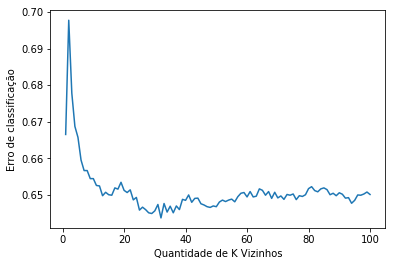

35.51


In [60]:
# Realizando cross validação para selecionar o melhor K
predicao = treino.drop(['AdoptionSpeed'], axis=1)
classe_esperada = treino['AdoptionSpeed']
media_acuracias = []
k_range = np.arange(1, 101)

for k in k_range:
    classificador_KNN = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(classificador_KNN, predicao, classe_esperada, cv=10)
    media_acuracias.append(np.mean(scores))
print(media_acuracias)

MSE = [1-x for x in media_acuracias]
#melhor K
indiceMelhorK = MSE.index(min(MSE))
melhorK = k_range[indiceMelhorK]
print("O MELHOR K FOI: {}".format(melhorK))
    
plt.plot(k_range, MSE)
plt.xlabel('Quantidade de K Vizinhos')
plt.ylabel('Erro de classificação')
plt.show()

# Realizando classificação com melhor K
classificador_KNN = KNeighborsClassifier(n_neighbors=melhorK)
classificador_KNN.fit(x_treino, y_treino)
y_predito = classificador_KNN.predict(x_validacao)
acuracia_KNN = round(accuracy_score(y_predito, y_validacao) * 100, 2)
print(acuracia_KNN)

Após rodar o K-Fold (K=10) em um range de 1-100 obteve-se que a melhor quantidade de vizinhos K foi 56 com acurácia média de **0.3684371191871951**. Apesar de parecer promissor a sua acurácia não ultrapassa os **37%**.

In [33]:
# Utilizando o SVM, para ver no que dá
# Okay, '36.88' foi uma melhora em relação à árvore de decisão
# Talvez se mexermos nos valores de gamma, o tipo de kernel, coeficiente e mudarmos a forma da função de decisão melhor a acurácia
# Vamos tentar
classificador_svm = SVC(gamma='auto')
classificador_svm.fit(x_treino, y_treino)
y_predito = classificador_svm.predict(x_validacao)
acuracia_svm = round(accuracy_score(y_predito, y_validacao) * 100, 2)
print(acuracia_svm)

35.61


In [35]:
# Agora utilizaremos um Gradien Boosting
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(x_treino, y_treino)
y_predito = gradient_boosting.predict(x_validacao)
acuracia_gradient_boosting = round(accuracy_score(y_predito, y_validacao) * 100, 2)
print(acuracia_gradient_boosting)

40.68


In [67]:
#Testando um AdaBoost
# Acurácia de 39.11 (n_estimators=100)

#estimadores_range = np.array([10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
#random_state = np.array([1, 2, 5, 7, 10, 15, 20, 30, 40, 50, 60])
#acuracia = []

#for estimador in estimadores_range:
#    classificador_ada_boost = AdaBoostClassifier(n_estimators=estimador, random_state=0)
#    scores = cross_val_score(classificador_ada_boost, predicao, classe_esperada, cv=10)
#    acuracia.append(np.mean(scores))
#print(acuracia)

#MSE = [1-x for x in acuracia]
#indiceMelhorE = MSE.index(min(MSE))
#melhorE = estimadores_range[indiceMelhorE]
#print("O MELHOR Nº DE ESTIMADORES FOI: {}".format(melhorE))
    
#plt.plot(estimadores_range, MSE)
#plt.xlabel('Quantidade de Estimadores')
#plt.ylabel('Erro de classificação')
#plt.show()


classificador_ada_boost = AdaBoostClassifier(n_estimators=200, random_state=0)
classificador_ada_boost.fit(x_treino, y_treino)
y_predito = classificador_ada_boost.predict(x_validacao)
acuracia_ada_boost = round(accuracy_score(y_predito, y_validacao) * 100, 2)
print(acuracia_ada_boost)


39.88


In [37]:
# Testando um RandomForestClassifier
classificador_rand_forest = RandomForestClassifier(max_depth=15, random_state=0, n_estimators=1000)
classificador_rand_forest.fit(x_treino, y_treino)
y_predito = classificador_rand_forest.predict(x_validacao)
acuracia_rand_forest = round(accuracy_score(y_predito, y_validacao) * 100, 2)
print(acuracia_rand_forest)

41.71


DT: 0.338492 (0.013128)
NB: 0.337490 (0.015715)
KNN: 0.350628 (0.012222)
SVM: 0.360502 (0.005902)
GBM: 0.407055 (0.010174)
RF: 0.419861 (0.010858)
AB: 0.389981 (0.012044)


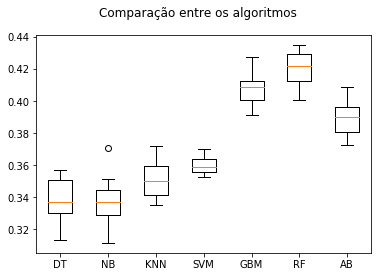

In [61]:
seed = 7

# preparandomodelos
models = []
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=56)))
models.append(('SVM', SVC(gamma='auto')))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier(max_depth=15, random_state=0, n_estimators=1000)))
models.append(('AB', AdaBoostClassifier(n_estimators=200, random_state=0)))

# avalia cada modelo por turno
results = []
names = []
scoring = 'accuracy'

predicao = treino.drop(['AdoptionSpeed'], axis=1)
classe_esperada = treino['AdoptionSpeed']

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, predicao, classe_esperada, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# Boxplot
fig = plt.figure()
fig.suptitle('Comparação entre os algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [62]:
# Quantidade de árvores
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Quantidade defeatures 
max_features = ['auto', 'sqrt']
# Máxima profundidade
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Número de amostras para cadasplit
min_samples_split = [2, 5, 10]
# Número mínimo de amostras para cada folha
min_samples_leaf = [1, 2, 4]
# Utilizar ou não bootstrap
bootstrap = [True, False]

# Cria a grid aleatoria
grid_aleatoria = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(grid_aleatoria)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
classificador_rand_forest = RandomForestClassifier()
classificador_rand_forest_random = RandomizedSearchCV(estimator = classificador_rand_forest, param_distributions = grid_aleatoria, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
classificador_rand_forest_random.fit(x_treino, y_treino)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
/opt/conda/lib/python3.6/site-pack

In [ ]:
def avaliaModelo(modelo, test_features, test_labels):
    predicoes = modelo.predict(test_features)
    errors = abs(predicoes - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    acuracia = 100 - mape
    
    print('Performance do modelo')
    print('Error Médio: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Acurácia = {:0.2f}%.'.format(acuracia))
    
    return acuracia

In [ ]:
# Os melhores parâmetros da randomGrid foram
print(classificador_rand_forest_random.best_params_)

classificador_rand_forest = RandomForestClassifier(n_estimators=1000, random_state = 0)
classificador_rand_forest.fit(x_treino, y_treino)

acuracia_base = avaliaModelo(classificador_rand_forest, x_validacao_novo, y_validacao)

melhor_random = classificador_rand_forest_random.best_estimator_
random_acuracia = avaliaModelo(melhor_random, x_validacao_novo, y_validacao)

print('Melhora de {:0.2f}%.'.format( 100 * (random_acuracia - acuracia_base) / acuracia_base))